# 영화 덧글 감성 분석 (한글처리)

네이버 영화에서 특정 영화에 대한 덧글 20만건을 크롤링한 데이터를 분석한다.
덧글에 적용된 별점을 기준으로 3점 이상은 긍정, 2점 이하는 부정으로 분류하였다.

#01. 작업 준비

## 형태소 분석엔진 설치

In [1]:
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
!bash Mecab-ko-for-Google-Colab/install_mecab-ko_on_colab_light_220429.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 138, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 138 (delta 26), reused 22 (delta 8), pack-reused 91
Receiving objects: 100% (138/138), 1.72 MiB | 6.46 MiB/s, done.
Resolving deltas: 100% (65/65), done.
Installing konlpy.....
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 39.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 44.8 MB/s eta 0:00:00
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2023-09-17 17:41:55--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22cd:e0db
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://bbuser

### 패키지 참조

In [2]:
import helper
import math
import numpy as np
import seaborn as sb
import requests

from pandas import DataFrame
from pandas import read_excel
from konlpy.tag import Mecab
from matplotlib import pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

#02. 데이터 셋 준비하기

### 리뷰 데이터 셋

In [3]:
origin = read_excel("https://data.hossam.kr/F03/movie_review.xlsx")
origin.head()

,label,document
0,부정,아 더빙.. 진짜 짜증나네요 목소리
1,긍정,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
2,부정,너무재밓었다그래서보는것을추천한다
3,부정,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
4,긍정,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...


### 불용어 데이터셋

#### 데이터셋 로드

In [4]:
r = requests.get("https://data.hossam.kr/korean_stopwords.txt")
r.encoding = 'utf-8'
r.text

'이\n있\n하\n것\n들\n그\n되\n수\n이\n보\n않\n없\n나\n사람\n주\n아니\n등\n같\n우리\n때\n년\n가\n한\n지\n대하\n오\n말\n일\n그렇\n위하\n때문\n그것\n두\n말하\n알\n그러나\n받\n못하\n일\n그런\n또\n문제\n더\n사회\n많\n그리고\n좋\n크\n따르\n중\n나오\n가지\n씨\n시키\n만들\n지금\n생각하\n그러\n속\n하나\n집\n살\n모르\n적\n월\n데\n자신\n안\n어떤\n내\n내\n경우\n명\n생각\n시간\n그녀\n다시\n이런\n앞\n보이\n번\n나\n다른\n어떻\n여자\n개\n전\n들\n사실\n이렇\n점\n싶\n말\n정도\n좀\n원\n잘\n통하\n소리\n놓\n!\n"\n$\n%\n&\n\'\n(\n)\n*\n+\n,\n-\n.\n...\n0\n1\n2\n3\n4\n5\n6\n7\n8\n9\n;\n<\n=\n>\n?\n@\n\\\n^\n_\n`\n|\n~\n·\n—\n——\n‘\n’\n“\n”\n…\n、\n。\n〈\n〉\n《\n》\n가\n가까스로\n가령\n각\n각각\n각자\n각종\n갖고말하자면\n같다\n같이\n개의치않고\n거니와\n거바\n거의\n것\n것과 같이\n것들\n게다가\n게우다\n겨우\n견지에서\n결과에 이르다\n결국\n결론을 낼 수 있다\n겸사겸사\n고려하면\n고로\n곧\n공동으로\n과\n과연\n관계가 있다\n관계없이\n관련이 있다\n관하여\n관한\n관해서는\n구\n구체적으로\n구토하다\n그\n그들\n그때\n그래\n그래도\n그래서\n그러나\n그러니\n그러니까\n그러면\n그러므로\n그러한즉\n그런 까닭에\n그런데\n그런즉\n그럼\n그럼에도 불구하고\n그렇게 함으로써\n그렇지\n그렇지 않다면\n그렇지 않으면\n그렇지만\n그렇지않으면\n그리고\n그리하여\n그만이다\n그에 따르는\n그위에\n그저\n그중에서\n그치지 않다\n근거로\n근거하여\n기대여\n기점으로\n기준으로\n기타\n까닭으로\n까악\n까지\n까지 미치다\n까지도\n꽈당\n끙끙\n끼익\n나\n나머지는\n남들\n남짓\n너\n너희\n너희들\n네\n넷\

#### 불용어만 리스트로 추출

In [5]:
stopwords = r.text.split("\n")
print(stopwords)

['이', '있', '하', '것', '들', '그', '되', '수', '이', '보', '않', '없', '나', '사람', '주', '아니', '등', '같', '우리', '때', '년', '가', '한', '지', '대하', '오', '말', '일', '그렇', '위하', '때문', '그것', '두', '말하', '알', '그러나', '받', '못하', '일', '그런', '또', '문제', '더', '사회', '많', '그리고', '좋', '크', '따르', '중', '나오', '가지', '씨', '시키', '만들', '지금', '생각하', '그러', '속', '하나', '집', '살', '모르', '적', '월', '데', '자신', '안', '어떤', '내', '내', '경우', '명', '생각', '시간', '그녀', '다시', '이런', '앞', '보이', '번', '나', '다른', '어떻', '여자', '개', '전', '들', '사실', '이렇', '점', '싶', '말', '정도', '좀', '원', '잘', '통하', '소리', '놓', '!', '"', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '...', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ';', '<', '=', '>', '?', '@', '\\', '^', '_', '`', '|', '~', '·', '—', '——', '‘', '’', '“', '”', '…', '、', '。', '〈', '〉', '《', '》', '가', '가까스로', '가령', '각', '각각', '각자', '각종', '갖고말하자면', '같다', '같이', '개의치않고', '거니와', '거바', '거의', '것', '것과 같이', '것들', '게다가', '게우다', '겨우', '견지에서', '결과에 이르다', '결국', '결론을 낼 수 있다', '겸사겸사', '고려하면', '고로', '곧', '공

## #03. 데이터 전처리

### 리뷰글에서 한글을 제외한 영어,특수문자 제거

In [6]:
df = origin.copy()

# 한글을 제외한 나머지 글자들을 빈 문자열로 대체
df['document'] = df['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", regex=True)

# document 컬럼의 데이터들 중에서 빈 문자열만 존재하는 항목은 결측치로 대체
df['document'].replace('', np.nan, inplace=True)

# 전체 데이터 셋 크기 확인
print('데이터 크기: ', df['document'].shape)

# 결측치 확인
print('결측치 크기: ', df['document'].isna().sum())

데이터 크기:  (200000,)
결측치 크기:  1091


### 결측치 정제

In [7]:
df.dropna(inplace=True)
df.isna().sum()

label       0
document    0
dtype: int64

### 종속 변수 라벨링

In [8]:
df['label'] = df['label'].replace({'긍정': 1, '부정': 0})
df['label'].value_counts()

1    99511
0    99398
Name: label, dtype: int64

### 리뷰글에 대한 형태소 분석

In [9]:
# 형태소 분석 엔진
mecab = Mecab()

# 문장내 형태소들을 저장할 리스트
word_set = []

# 덧글 내용에 대해 반복 처리
for i, v in enumerate(df['document']):
    # 덧글 하나에 대한 형태소 분석
    morphs = mecab.morphs(v)
    # print(morphs)
    # if i > 5:
    #     break

    # 형태소 분석 결과에서 불용어를 제외한 단어만 별도의 리스트로 생성
    confirm_words = []
    for j in morphs:
        if j not in stopwords:
            confirm_words.append(j)

    # 불용어를 제외한 형태소 리스트를 통째로 word_set에 저장함
    # -> word_set은 2차원 리스트가 된다. 1차원이 덧글 단위임
    word_set.append(confirm_words)

# 상위 3건만 출력해서 확인
word_set[:3]

[['빙', '진짜', '짜증', '네요', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '가볍', '구나'],
 ['너무', '재', '밓었다그래서보는것을추천한다']]

### 형태소 토큰화

#### 전체 단어에 대한 토큰화

In [10]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(word_set)
print(f'전체 단어수: {len(tokenizer.word_index)}')

전체 단어수: 56311


#### 각 단어별 빈도수 확인

`(단어: 빈도수)` 형태의 튜플을 원소로 갖는 리스트를 반환

In [11]:
tokenizer.word_counts.items()

odict_items([('빙', 349), ('진짜', 11263), ('짜증', 2002), ('네요', 11911), ('목소리', 511), ('흠', 308), ('포스터', 745), ('보고', 1166), ('초딩', 571), ('영화', 77238), ('줄', 3817), ('오버', 189), ('연기', 9165), ('가볍', 331), ('구나', 1052), ('너무', 14739), ('재', 2297), ('밓었다그래서보는것을추천한다', 1), ('교도소', 23), ('이야기', 2949), ('구먼', 47), ('솔직히', 1424), ('재미', 5481), ('는', 89382), ('다', 73520), ('평점', 8484), ('조정', 58), ('사이몬페그', 2), ('익살', 16), ('스런', 301), ('돋보였', 80), ('던', 7915), ('스파이더맨', 79), ('늙', 265), ('기', 10694), ('만', 15739), ('했', 10722), ('커스틴', 6), ('던스트', 4), ('너무나', 927), ('도', 45499), ('이뻐', 72), ('보였', 154), ('막', 548), ('걸음마', 2), ('뗀', 4), ('세', 874), ('초등', 183), ('학교', 536), ('학년', 171), ('생', 584), ('인', 9540), ('살용', 1), ('ㅋㅋㅋ', 7229), ('별반', 99), ('아까움', 468), ('원작', 1704), ('긴장감', 1108), ('제대로', 1060), ('살려', 127), ('못했', 414), ('별', 1981), ('반개', 227), ('아깝', 3268), ('욕', 935), ('나온다', 476), ('이응경', 8), ('길용우', 4), ('생활', 199), ('인지', 1773), ('정말', 13030), ('발', 386), ('해도', 1211), ('보단', 

#### 3회 이상 자주 등장하는 단어의 수 구하기

In [12]:
# 사용 빈도가 높다고 판단할 등장 회수
threshold = 3

# 전체 단어의 수
total_cnt = len(tokenizer.word_index)

# 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트할 값
rare_cnt = 0

# 훈련 데이터의 전체 단어 빈도수 총 합
total_freq = 0

# 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합
rare_freq = 0

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 미만인 희귀 단어의 수: %s' % (threshold, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

# 자주 등장하는 단어 집합의 크기 구하기 -> 이 값이 첫 번째 학습층의 input 수가 된다.
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :', vocab_size)

단어 집합(vocabulary)의 크기 : 56311
등장 빈도가 3번 미만인 희귀 단어의 수: 31490
단어 집합에서 희귀 단어의 비율: 55.921578377226474
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.7985328412428183
단어 집합의 크기 : 24823


#### 자주 등장하는 단어를 제외한 나머지 단어를 OOV로 처리하여 최종 토큰화 진행

In [13]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')
tokenizer.fit_on_texts(word_set)
token_set = tokenizer.texts_to_sequences(word_set)
print('토큰의 크기 :', len(token_set))

토큰의 크기 : 198909


#### 토큰화 결과의 길이가 0인 항목 찾기

In [14]:
# 토큰화 결과 길이가 0인 항목의 index 찾기
drop_target_index = []

for i, v in enumerate(token_set):
    if len(v) < 1:
        drop_target_index.append(i)

print("길이가 0인 항목의 수: ", len(drop_target_index))

print("길이가 0인 항목의 인덱스 모음: ", drop_target_index)

길이가 0인 항목의 수:  985
길이가 0인 항목의 인덱스 모음:  [151, 159, 404, 412, 470, 795, 1307, 1480, 1544, 2206, 2220, 2287, 2365, 2572, 3290, 3498, 3549, 4332, 4417, 4712, 4875, 4950, 5003, 5090, 5110, 5195, 5335, 5745, 5843, 5847, 6224, 6371, 6430, 7095, 7221, 7389, 7544, 7594, 8145, 8595, 8751, 9205, 9208, 9476, 9539, 9586, 9630, 9989, 10000, 10091, 10675, 10713, 10741, 11258, 11711, 11988, 12100, 12467, 12484, 13159, 13579, 13727, 13859, 13871, 14055, 14306, 14390, 14428, 14675, 14812, 15360, 15714, 15715, 16029, 16202, 16504, 17232, 17596, 17713, 17976, 18116, 18715, 19039, 19418, 19534, 19637, 19868, 20342, 20676, 20768, 20815, 20866, 21064, 21111, 21624, 22032, 22271, 22410, 22453, 22470, 22566, 22729, 22739, 22745, 22854, 23061, 23078, 23098, 23277, 23329, 23362, 23557, 23710, 24205, 24695, 24892, 25118, 26087, 26124, 26145, 26150, 26158, 26435, 26913, 27592, 28075, 28133, 28311, 28917, 28943, 29268, 29323, 29620, 30002, 30015, 30016, 30550, 30580, 30607, 30867, 30883, 30960, 30973, 31390, 31543,

#### 토큰화 결과의 길이가 0인 항목 삭제하기

In [15]:
# 토큰 결과에서 해당 위치의 항목들을 삭제한다.
fill_token_set = np.delete(token_set, drop_target_index, axis=0)

# 종속변수에서도 같은 위치의 항목들을 삭제해야 한다.
label_set = np.delete(df['label'].values, drop_target_index, axis=0)

print("독립변수(덧글) 데이터 수: ", len(fill_token_set))
print("종속변수(레이블) 데이터 수: ", len(label_set))

독립변수(덧글) 데이터 수:  197924
종속변수(레이블) 데이터 수:  197924


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:5071: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


## #04. 탐색적 데이터 분석

### 1) 각 문장별로 몇 개의 단어를 포함하고 있는지 측정

In [16]:
word_counts = []

for s in fill_token_set:
    word_counts.append(len(s))

print(word_counts)

[5, 10, 3, 9, 20, 15, 6, 34, 7, 15, 1, 17, 14, 15, 22, 8, 23, 11, 14, 10, 15, 7, 45, 9, 6, 15, 4, 2, 4, 7, 19, 7, 6, 8, 6, 5, 14, 8, 5, 6, 5, 27, 5, 8, 27, 8, 43, 18, 4, 47, 16, 13, 9, 14, 2, 1, 1, 32, 2, 3, 9, 9, 8, 32, 13, 37, 25, 15, 9, 13, 6, 39, 1, 8, 5, 16, 7, 2, 16, 3, 13, 4, 17, 5, 4, 5, 3, 3, 5, 9, 6, 7, 2, 3, 5, 8, 4, 6, 7, 13, 11, 7, 9, 8, 7, 15, 2, 5, 8, 11, 10, 13, 6, 1, 17, 2, 6, 5, 10, 5, 27, 16, 6, 2, 2, 8, 3, 11, 41, 12, 1, 4, 4, 12, 5, 7, 12, 5, 10, 14, 1, 11, 37, 3, 5, 6, 23, 19, 11, 41, 9, 12, 5, 3, 4, 20, 10, 4, 6, 12, 7, 43, 37, 15, 3, 16, 10, 1, 30, 41, 10, 6, 4, 15, 3, 4, 11, 7, 41, 6, 32, 3, 18, 1, 7, 5, 25, 6, 3, 19, 13, 20, 14, 14, 4, 13, 13, 20, 6, 10, 6, 42, 11, 5, 11, 4, 13, 5, 3, 6, 6, 12, 3, 10, 10, 10, 11, 7, 22, 8, 19, 9, 6, 11, 3, 7, 23, 8, 26, 8, 47, 41, 6, 3, 9, 13, 10, 5, 7, 10, 8, 9, 13, 11, 8, 3, 6, 6, 17, 4, 4, 2, 10, 7, 8, 4, 14, 6, 19, 5, 13, 11, 4, 4, 35, 6, 7, 7, 2, 7, 3, 8, 5, 13, 17, 2, 1, 9, 35, 9, 16, 30, 6, 4, 15, 2, 18, 8, 41, 3, 8, 28

### 2) 리뷰 중 가장 많은 단어를 사용한 리뷰와 가장 적은 단어를 사용한 리뷰의 단어 수

In [17]:
max_word_count = max(word_counts)
min_word_count = min(word_counts)
print('리뷰의 최대 단어수 :',max_word_count)
print('리뷰의 최대 단어수 :',min_word_count)

리뷰의 최대 단어수 : 70
리뷰의 최대 단어수 : 1


### 3) 히스토그램으로 단어 분포 수 확인

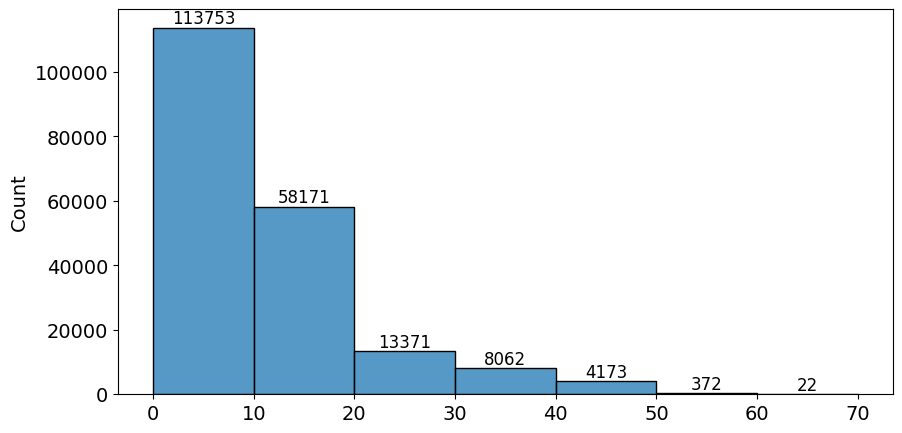

In [18]:
# 히스토그램의 범위 산정
hist_values, hist_bins = np.histogram(word_counts, range=(0, max_word_count), bins=7)
hist_bins = hist_bins.astype(np.int64)

plt.figure(figsize=(10, 5))
sb.histplot(word_counts, bins=7, binrange=(0, max_word_count))
plt.xticks(hist_bins, hist_bins)

for i, v in enumerate(hist_values):
    x = hist_bins[i] + ((hist_bins[i+1] - hist_bins[i]) / 2)
    plt.text(x=x, y=v, s=str(v), fontsize=12, verticalalignment='bottom', horizontalalignment='center')

plt.show()
plt.close()

## #05. 데이터셋 분할하기

### 1. 랜덤 시드 고정

In [19]:
np.random.seed(777)

### 2. 패딩처리

최대 단어수를 갖고 있는 문장을 기준으로 그보다 적은 단어를 갖고 있는 문장은 최대 단어수와 동일해 질 때까지 0으로 채워넣는다.

In [20]:
max_word_count = max(word_counts)
pad_token_set = pad_sequences(fill_token_set, maxlen=max_word_count)
pad_token_set

array([[   0,    0,    0, ...,  144,   17,  554],
       [   0,    0,    0, ...,   26,  803,  279],
       [   0,    0,    0, ...,   12,  126,    1],
       ...,
       [   0,    0,    0, ..., 2551,    8, 1239],
       [   0,    0,    0, ...,    4,   32,  226],
       [   0,    0,    0, ...,    0,  765,    2]], dtype=int32)

### 3. 데이터 분할

In [21]:
x_train, x_test, y_train, y_test = train_test_split(pad_token_set, label_set, test_size = 0.3, random_state = 777)
print("훈련용 데이터셋 크기: %s, 검증용 데이터셋 크기: %s" % (x_train.shape,  x_test.shape))
print("훈련용 레이블 크기: %s, 검증용 레이블 크기: %s" % (y_train.shape,  y_test.shape))

훈련용 데이터셋 크기: (138546, 70), 검증용 데이터셋 크기: (59378, 70)
훈련용 레이블 크기: (138546,), 검증용 레이블 크기: (59378,)


## #06. 모델 개발

### 모델 정의

In [22]:
#모델 개발
model = Sequential()

# input_dim의 크기는 토큰 생성시 지정한 최대 단어수(vocab_size)와 동일하게 설정
# output_dim의 크기는 input_dim보다 작은 값 중에서 설정
model.add(Embedding(input_dim = vocab_size, output_dim = 32))
model.add(GRU(128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          794336    
                                                                 
 gru (GRU)                   (None, 128)               62208     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 856673 (3.27 MB)
Trainable params: 856673 (3.27 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


### 학습하기

In [23]:
result = model.fit(x_train, y_train, batch_size = 10, epochs = 500, validation_data=(x_test, y_test), callbacks = [
    EarlyStopping(monitor = 'val_loss', patience=5, verbose = 1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.0001, verbose=1)
])

Epoch 1/500
13855/13855 [==============================] - 115s 8ms/step - loss: 0.3872 - acc: 0.8224 - val_loss: 0.3571 - val_acc: 0.8407 - lr: 0.0010
Epoch 2/500
13855/13855 [==============================] - 83s 6ms/step - loss: 0.3126 - acc: 0.8649 - val_loss: 0.3518 - val_acc: 0.8441 - lr: 0.0010
Epoch 3/500
13855/13855 [==============================] - 85s 6ms/step - loss: 0.2715 - acc: 0.8857 - val_loss: 0.3567 - val_acc: 0.8424 - lr: 0.0010
Epoch 4/500
13855/13855 [==============================] - 84s 6ms/step - loss: 0.2322 - acc: 0.9046 - val_loss: 0.3752 - val_acc: 0.8368 - lr: 0.0010
Epoch 5/500
13850/13855 [============================>.] - ETA: 0s - loss: 0.1940 - acc: 0.9219
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
13855/13855 [==============================] - 84s 6ms/step - loss: 0.1940 - acc: 0.9219 - val_loss: 0.4119 - val_acc: 0.8312 - lr: 0.0010
Epoch 6/500
13855/13855 [==============================] - 83s 6ms/step - loss: 0.14

## #06. 학습결과 평가

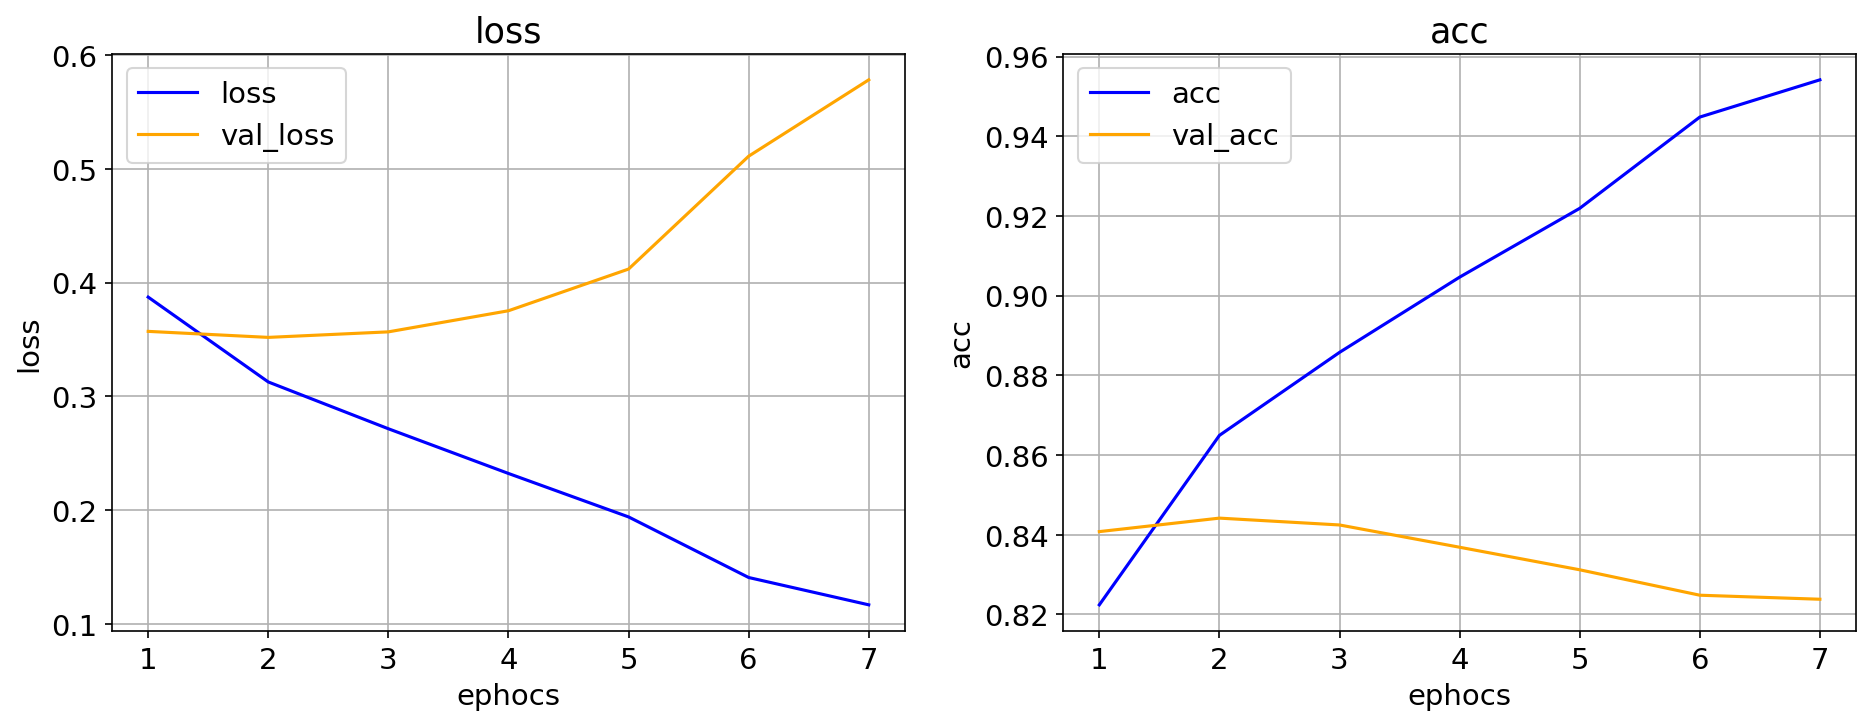

4330/4330 [==============================] - 13s 3ms/step - loss: 0.0902 - acc: 0.9666
최종 훈련 손실률: 0.090203, 최종 훈련 정확도: 0.966574
1856/1856 [==============================] - 6s 3ms/step - loss: 0.5783 - acc: 0.8238
최종 검증 손실률: 0.578250, 최종 검증 정확도: 0.823773


In [24]:
helper.tf_result_plot(result)

evaluate1 = model.evaluate(x_train, y_train)
print("최종 훈련 손실률: %f, 최종 훈련 정확도: %f" % (evaluate1[0], evaluate1[1]))

evaluate2 = model.evaluate(x_test, y_test)
print("최종 검증 손실률: %f, 최종 검증 정확도: %f" % (evaluate2[0], evaluate2[1]))

## #07. 학습 결과 적용

### 검증 데이터에 대한 예측 결과 산정

In [25]:
result = model.predict(x_train, batch_size=10)
data_count, case_count = result.shape
print("%d개의 검증 데이터가 %d개의 경우의 수를 갖는다." % (data_count, case_count))
result

13855/13855 [==============================] - 31s 2ms/step
138546개의 검증 데이터가 1개의 경우의 수를 갖는다.


array([[8.417447e-02],
       [7.415830e-05],
       [3.162051e-06],
       ...,
       [4.214538e-02],
       [9.968279e-01],
       [9.647485e-01]], dtype=float32)

### 예측 결과를 1차원 배열로 변환

In [26]:
f_results = result.flatten()
f_results

array([8.417447e-02, 7.415830e-05, 3.162051e-06, ..., 4.214538e-02,
       9.968279e-01, 9.647485e-01], dtype=float32)

### 학습 결과 확인

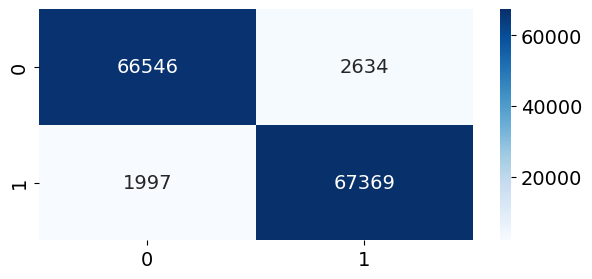

In [27]:
kdf = DataFrame({
    'train': y_train,
    'pred' : np.round(f_results)
})

kdf['pred'] = kdf['pred'].astype('int')

cm = confusion_matrix(kdf['train'], kdf['pred'])

plt.figure(figsize=(7, 3))
sb.heatmap(cm, annot = True, fmt = 'd',cmap = 'Blues')
plt.show()
plt.close()

## #08. 임의의 문장에 대한 분류

In [34]:
# 임의의 문장
comment = [
        "오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 재미있는 영화를 만났습니다 강렬하게 유쾌함",
        "시간 때우기에도 아까운 영화",
        "시나리오에 아까운 캐스팅. 시간만 아까웠다.",
        "강력 추천~!!!",
        "감독의 유머감각이 나와 잘 맞는듯 하다. 유쾌하게 봤다."
]

# 형태소 분석 엔진
mecab = Mecab()

# 불용어를 제거한 형태소들이 저장될 리스트
word_set = []

# 문장 수 만큼 반복
for c in comment:
    # 형태소 분석
    morphs = mecab.morphs(c)
    # 불용어 제거
    tmp_word = []
    for j in morphs:
        if j not in stopwords:
            tmp_word.append(j)

    word_set.append(tmp_word)

# 자주 등장하는 단어를 제외한 나머지 단어를 OOV로 처리하여 최종 토큰화 수행
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')
tokenizer.fit_on_texts(word_set)
token_set = tokenizer.texts_to_sequences(word_set)

# 최대 길이에 맞춰서 패딩 처리
pad_token_set = pad_sequences(token_set, maxlen=max_word_count)

# 전처리가 완료된 말뭉치를 학습모델에 적용하여 예측하기
result = model.predict(pad_token_set)

# 결과 분석
for i, v in enumerate(result.flatten()):
    p = np.round(v * 100, 1)

    if p > 50:
        print("%.1f%%의 확률로 긍정입니다. >> %s" % (p, comment[i]))
    else:
        print("%.1f%%의 확률로 부정입니다. >> %s" % (100-p, comment[i]))

1/1 [==============================] - 0s 23ms/step
98.7%의 확률로 긍정입니다. >> 오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 재미있는 영화를 만났습니다 강렬하게 유쾌함
63.9%의 확률로 긍정입니다. >> 시간 때우기에도 아까운 영화
61.7%의 확률로 부정입니다. >> 시나리오에 아까운 캐스팅. 시간만 아까웠다.
99.6%의 확률로 긍정입니다. >> 강력 추천~!!!
61.5%의 확률로 부정입니다. >> 감독의 유머감각이 나와 잘 맞는듯 하다. 유쾌하게 봤다.
